In [1]:
# %%
from fbprophet import Prophet
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 10) # for Prophet plot when applying log transform
import numpy as np
import pandas as pd
import sklearn.metrics

In [ ]:
# test with other smoothing functions

In [2]:
# %%
df = pd.read_csv('emerging_risks_doc_count_twitter.csv')

try:
    df.drop([381, 382, 383],inplace=True) # drop rows 381, 382, 383 as they are 0 values
    df.index = pd.to_datetime(df.date)    # set date as index
except KeyError:                          # have already been dropped
    pass

In [3]:
topic = df.Pesticides

In [4]:
def mean_absolute_percentage_error(y_true, y_pred):
    if len(y_true) != len(y_pred):
        raise ValueError(f"len y_true is {len(y_true)}, len y_pred is {len(y_true)}" )
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [36]:
def prophetize(ser, prediction_length=28, holidays=False, changepoint_prior_scale=0.05, apply_log=False) \
        -> dict:
    """
    Plot fit and prediction, print error measurements, return dict 
    {'MAPE': float, 'R2': float, 'RMSE': float, 'Model': Prophet, 'Future': pd.DataFrame}.
    """
    if type(holidays) is str:
        m = Prophet(changepoint_prior_scale=changepoint_prior_scale)
        m.add_country_holidays(country_name=holidays)
    elif type(holidays) is pd.DataFrame:
        m = Prophet(holidays=holidays, changepoint_prior_scale=changepoint_prior_scale)
    elif holidays is False:
        m = Prophet(changepoint_prior_scale=changepoint_prior_scale)
    else:
        raise TypeError(f"holidays must be str, pd.DataFrame or False, is {type(holidays)} instead.")
    
    m.add_seasonality(name='quarterly', period=120, fourier_order=5)
    
    df = pd.DataFrame()
    if apply_log is False:
        df["y"] = ser
    else:
        df["y"] = np.log(ser)
    df["ds"] = ser.index

    m.fit(df)
    future = m.make_future_dataframe(periods=prediction_length)
    forecast = m.predict(future)

    if apply_log is True:
        for col_name in ('yhat', 'yhat_lower', 'yhat_upper'):
            forecast[col_name] = np.exp(forecast[col_name])
        df.y = np.exp(df.y)
        
    pred = forecast.yhat[:-prediction_length] 
    mape = mean_absolute_percentage_error(df.y, pred)
    rsquared = sklearn.metrics.r2_score(df.y, pred)
    rmse = sklearn.metrics.mean_squared_error(df.y, pred, squared=False)
    res = {"MAPE": mape, "R2": rsquared, "RMSE": rmse}
    for k, v in res.items():
        print(k, " : ", v) 
    res["Model"] = m
    res["Future"] = future
    
    if apply_log is False:
        m.plot(forecast)
        plt.show()        
    
    else:
        forecast.set_index(forecast.ds, inplace=True)
        fig, ax1 = plt.subplots()
        ax1.plot(df.y)
        ax1.plot(forecast.yhat, color='black', linestyle=':')
        ax1.fill_between(forecast.index, forecast['yhat_upper'], forecast['yhat_lower'], alpha=0.5, 
                         color='darkgray')
    return res

# SIMPLE Prophet

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAPE  :  52.713696931095946
R2  :  0.11966541791223473
RMSE  :  404.36459780161397


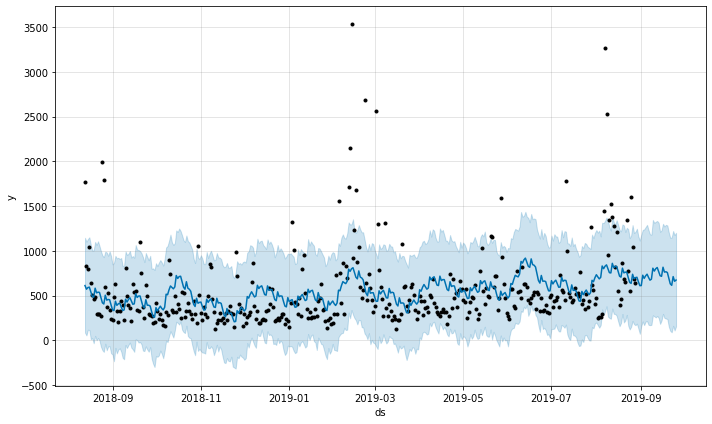

In [37]:
simple = prophetize(topic)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAPE  :  39.312292624749205
R2  :  0.07711529485861923
RMSE  :  414.02157106305253


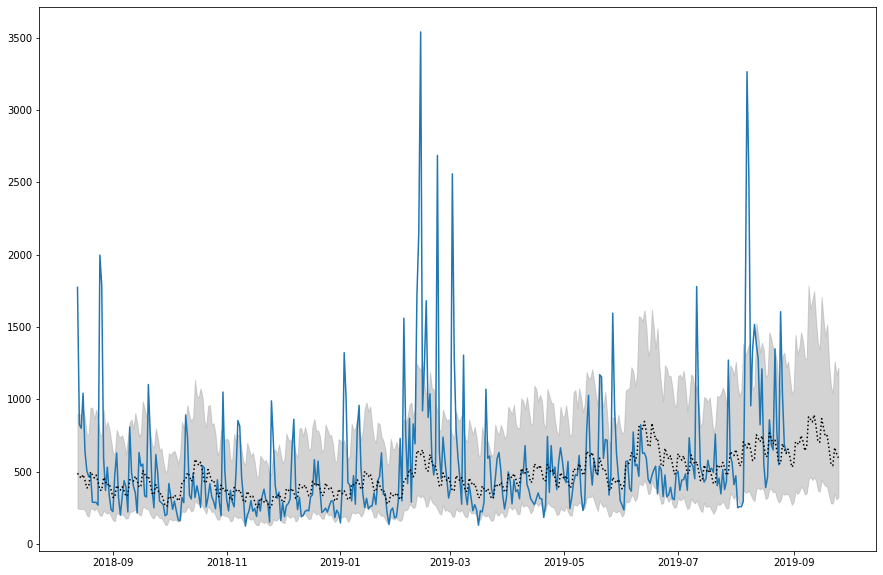

In [38]:
simple = prophetize(topic, apply_log=True)

# US Holidays
MAPE lowers by 2%: 2 peaks (on the general dataset as well) seem to be correlated with 2 US holidays
### Watch out:
Since we only have 1 year, we cannot really take into account the impact of holidays. We will see overfitting
bias

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAPE  :  50.55784306405574
R2  :  0.14295766344606076
RMSE  :  398.9793171581157


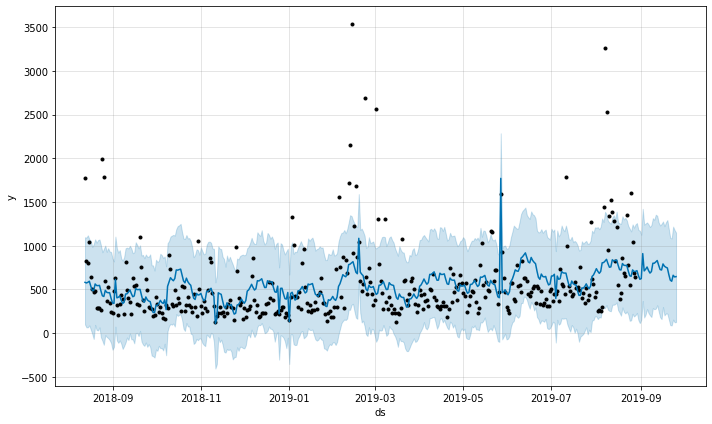

In [39]:
us = prophetize(topic, holidays="US")

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAPE  :  37.727865772282115
R2  :  0.1066522193445335
RMSE  :  407.34231399119375


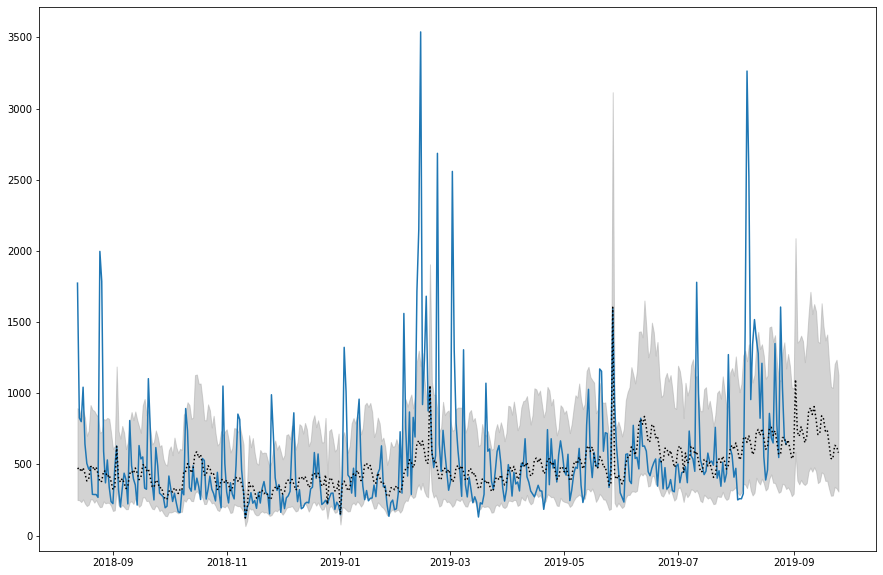

In [40]:
us = prophetize(topic, holidays="US", apply_log=True)

# French holidays
Interetingly enough, French holidays seem to be correlated with 2 other peaks.
We probably see this because the dataset is global.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAPE  :  53.89315498992842
R2  :  0.06775451541025768
RMSE  :  416.11597499943986


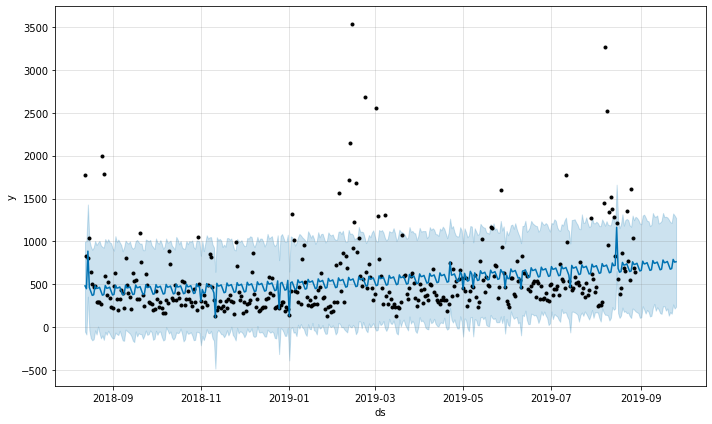

In [10]:
fr = prophetize(topic, holidays="FRA")

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAPE  :  39.25567796710766
R2  :  0.038007424292265335
RMSE  :  422.70278081998515


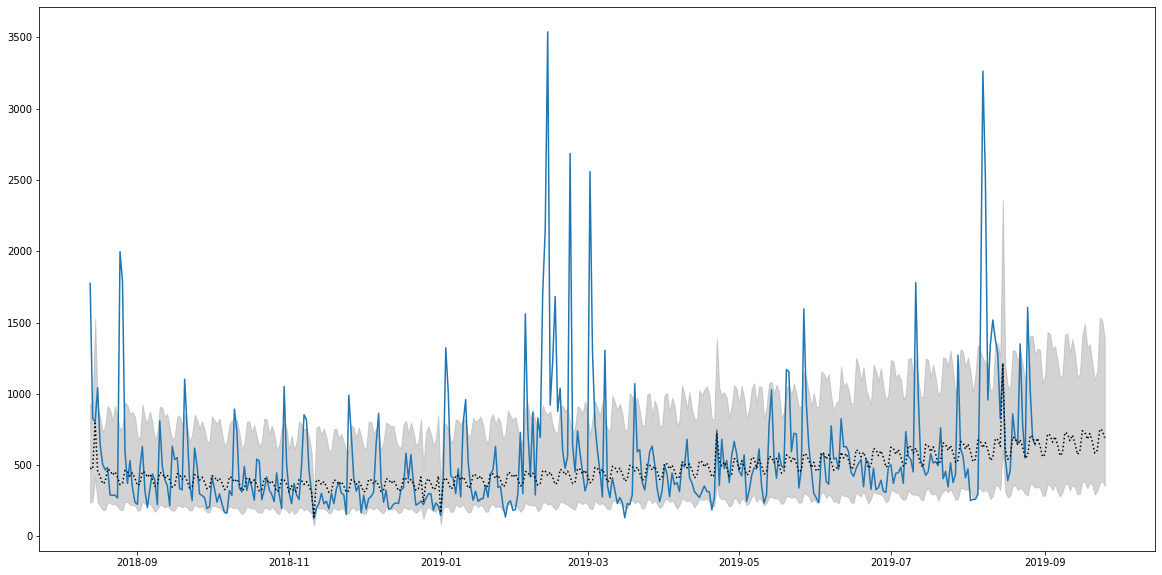

In [11]:
fr = prophetize(topic, holidays="FRA", apply_log=True)

# Reductio ad absurdum
Let's see how much the MAPE would get down if I knew in advance all top and bottom periods on the dataset as 
a whole

In [12]:
# %%
# ds_outliers lists the top/bottom days of the dataset as a whole
#h_full = pd.read_csv('C:/Users/Lorenzo/Desktop/MyStuff/Master/Paris/Bloom/Prophet/data/artefact_holidays.csv')
h_full = pd.read_csv('C:/Users/Lorenzo/Desktop/MyStuff/Master/Paris/Bloom/Prophet/data/ds_outliers.csv')
# h_full = pd.read_csv('ds_outliers.csv')
h_full.ds = pd.to_datetime(h_full.ds)
h_full.lower_window = pd.to_numeric(h_full.lower_window)
h_full.upper_window = pd.to_numeric(h_full.upper_window)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAPE  :  40.78271627103678
R2  :  0.3016773525113001
RMSE  :  360.1449324401238


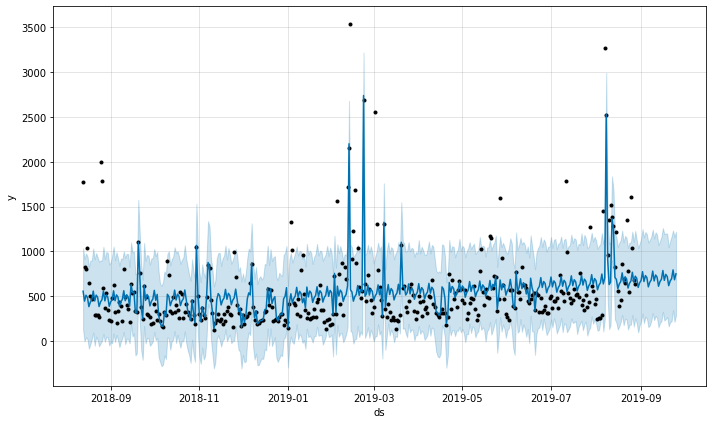

In [13]:
cheating = prophetize(topic, holidays=h_full)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAPE  :  29.795834234568307
R2  :  0.27557059534967243
RMSE  :  366.8151630174695


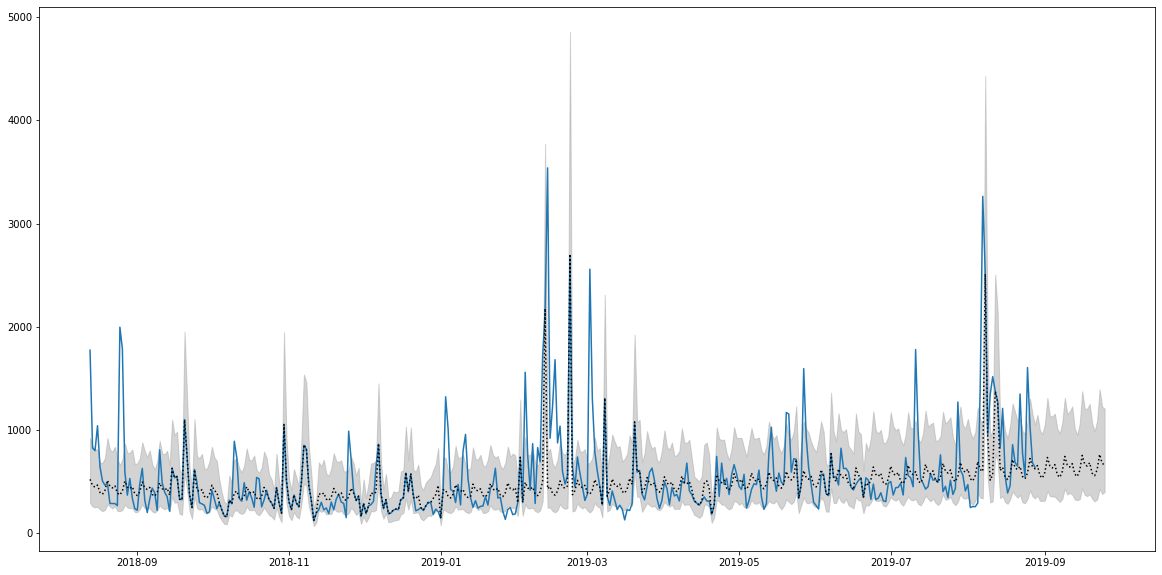

In [14]:
cheating = prophetize(topic, holidays=h_full, apply_log=True)

# a MAPE of 41% is still extremely high. The model is not able to reliably fit the data.
Now I try to increase the "flexibility" of the model with the parameter changepoint_prior_scale

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAPE  :  33.33585246549464
R2  :  0.4555754297996648
RMSE  :  317.9933977946001


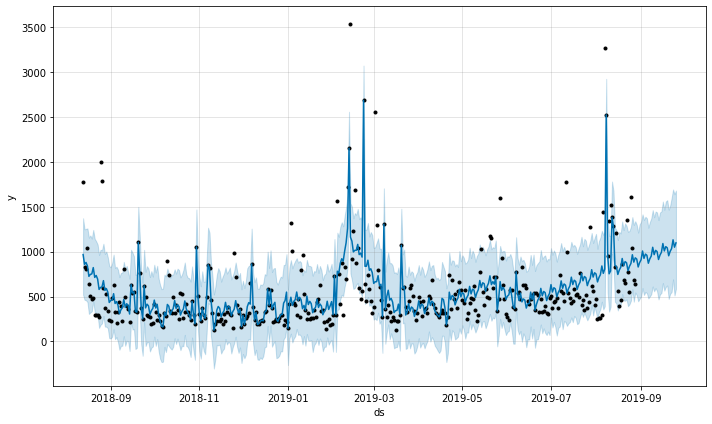

In [15]:
flex_cheating = prophetize(topic, holidays=h_full, changepoint_prior_scale=3)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAPE  :  24.620291546028543
R2  :  0.44236509810795965
RMSE  :  321.828290822529


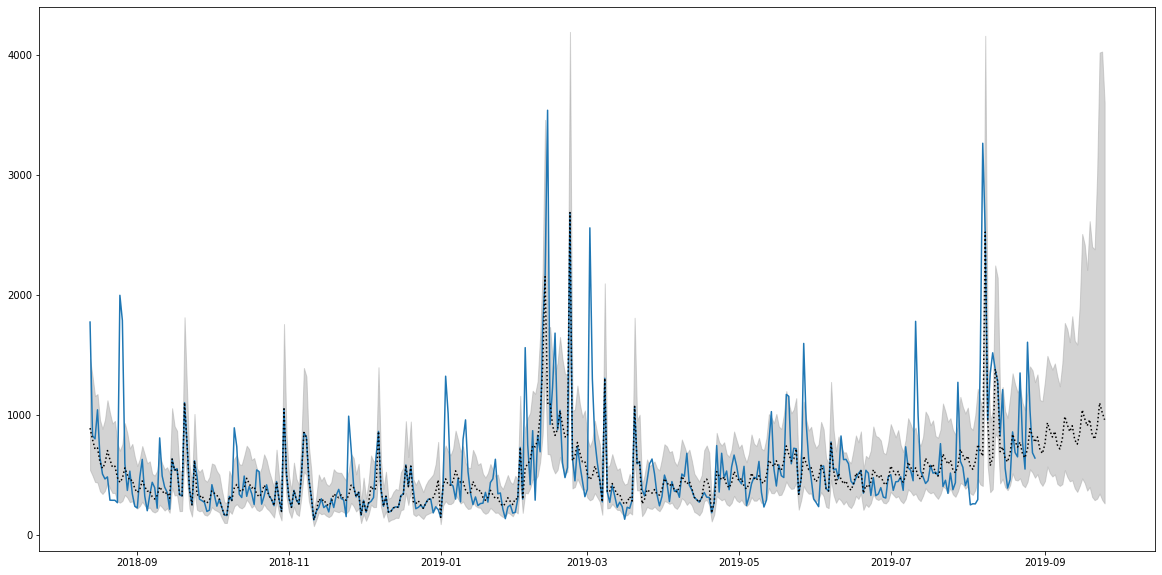

In [16]:
flex_cheating = prophetize(topic, holidays=h_full, changepoint_prior_scale=3, apply_log=True)

# Increasing the flexibility lowers the MAPE to an almost acceptable MAPE of 32%, but we see an increase in overfitting

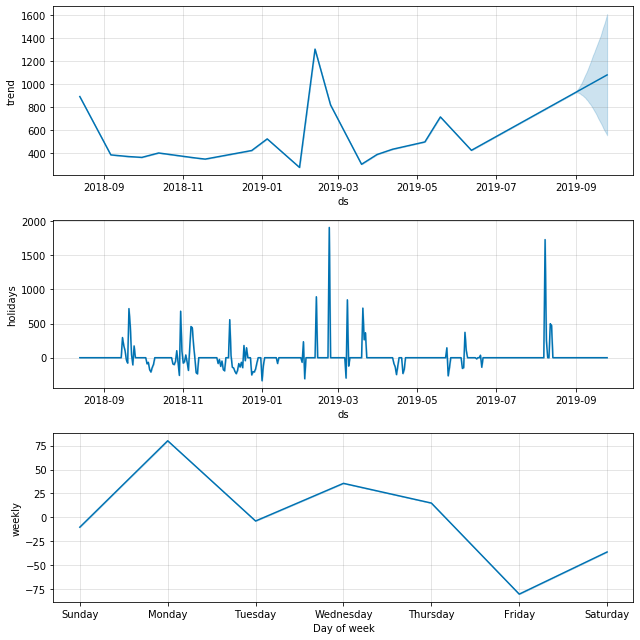

In [34]:
# %%
fig2 = m.plot_components(forecast)
plt.show()

In [35]:
# diagnostics take a long computing time
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='180 days', period='28 days', horizon = '14 days')
df_cv.head()

INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-02-27 00:00:00 and 2019-08-14 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-02-28,1057.191344,664.045067,1460.892488,319.0,2019-02-27
1,2019-03-01,1051.566685,676.055803,1435.705363,381.0,2019-02-27
2,2019-03-02,1104.122488,736.948467,1523.663660,2559.0,2019-02-27
3,2019-03-03,1082.614597,671.826590,1472.946826,1301.0,2019-02-27
4,2019-03-04,1221.590004,836.436809,1642.988761,790.0,2019-02-27


In [36]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,2 days,101057.285809,317.895086,242.113185,0.554332,0.340970,0.825397
1,3 days,287560.219123,536.246416,316.874193,0.453076,0.213088,0.746032
2,4 days,124456.831252,352.784398,263.513976,0.479635,0.447244,0.936508
3,5 days,146785.960589,383.126559,322.207059,0.482109,0.546316,0.777778
4,6 days,113477.580220,336.864335,300.335211,0.542818,0.546316,0.825397


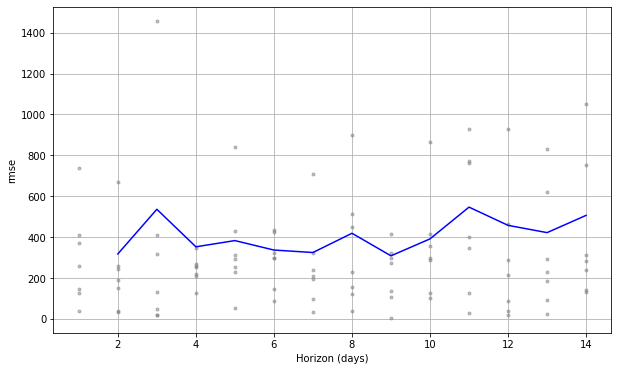

In [37]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='rmse')

In [15]:
from pmdarima import auto_arima

stepwise_model = auto_arima(topic, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
Fit ARIMA: (1, 1, 1)x(0, 1, 1, 12) (constant=True); AIC=5452.904, BIC=5472.444, Time=9.303 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 12) (constant=True); AIC=5754.285, BIC=5762.102, Time=0.089 seconds
Fit ARIMA: (1, 1, 0)x(1, 1, 0, 12) (constant=True); AIC=5636.006, BIC=5651.639, Time=3.687 seconds
Fit ARIMA: (0, 1, 1)x(0, 1, 1, 12) (constant=True); AIC=5489.260, BIC=5504.892, Time=5.335 seconds
Near non-invertible roots for order (0, 1, 1)(0, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 12) (constant=False); AIC=5752.286, BIC=5756.194, Time=0.047 seconds
Fit ARIMA: (1, 1, 1)x(0, 1, 0, 12) (constant=True); AIC=5648.011, BIC=5663.644, Time=1.302 seconds
Near non-invertible roots for order (1, 1, 1)(0, 1, 0, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (1, 1, 1)x(1, 1, 1, 12) (constant

In [47]:
res = stepwise_model.fit(topic)

In [48]:
future_forecast = stepwise_model.predict(n_periods=28)

In [49]:
future_forecast

array([ 807.73595684,  879.50594399,  952.2946766 ,  987.34484269,
        960.80117603,  957.27931262,  979.882492  , 1000.06194034,
        909.98371836,  900.44166515,  949.01729647,  915.03941517,
        946.29968873,  962.54029969, 1012.63439037, 1038.47546267,
       1008.26134942, 1003.34381629, 1025.48559916, 1045.58736618,
        955.5890585 ,  946.19164563,  994.93850094,  961.14276178,
        992.58966168, 1009.01874067, 1059.30205579, 1085.3326632 ])

In [27]:
from statsmodels import tsa
r = tsa.statespace.sarimax.SARIMAX(topic, order=(1, 1, 1), seasonal_order=(0, 1, 1, 12))

C:\Users\Lorenzo\miniconda3\envs\Prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Lorenzo\miniconda3\envs\Prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



In [58]:
fit_sarimax = r.fit()

C:\Users\Lorenzo\miniconda3\envs\Prophet\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



In [61]:
# In-sample one-step-ahead predictions
predict = fit_sarimax.get_prediction()
predict_ci = predict.conf_int()

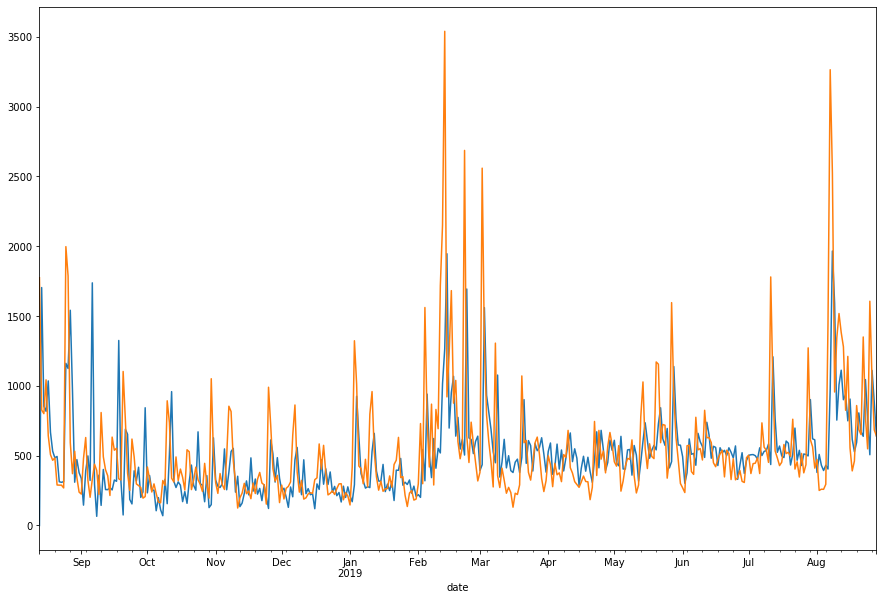

In [64]:
predict.predicted_mean.plot()
topic.plot()

In [66]:
mean_absolute_percentage_error(topic, predict.predicted_mean)

42.659659267039366

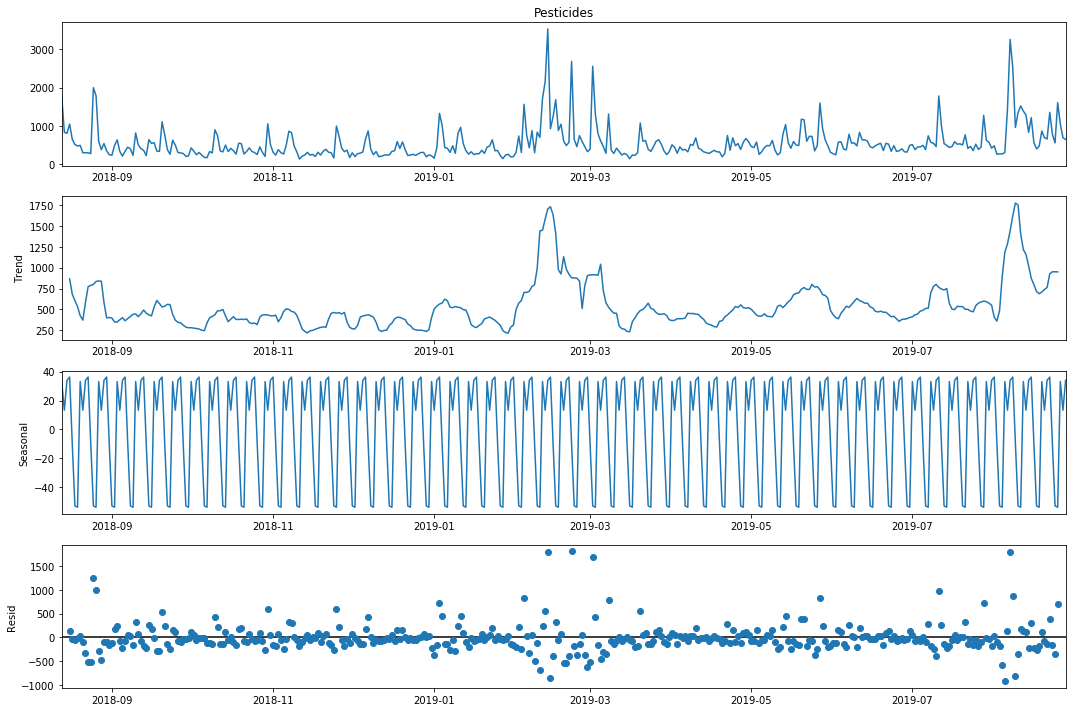

In [69]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(topic, model='additive')
fig = result.plot()